In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

In [3]:
with open('/Users/trader/Downloads/fee_record3.csv', 'r') as f:
    data = f.readlines()
filted_data = []
lens = []
for i in data:
    l = i.split(',')
    if len(l) > 20:
        if len(l) > 400:
            
            filted_data.append(l[:26] + l[206:226])
            lens.append(len(l[:26] + l[206:226]))
            
        else:
            lens.append(len(l))
            filted_data.append(l)
for i in filted_data:
    for j in range(6, len(i)):
        i[j] = eval(i[j])

filted_data = pd.DataFrame(filted_data)
filted_data.index = pd.to_datetime(filted_data[0])
filted_data.sort_index(inplace=True)
filted_data[3] = filted_data[3].astype('float')
filted_data[5] = filted_data[5].astype('float')

In [6]:
c1 = ['time','ex','symbol','fee', 'time2', 'fee_diff']
for i in range(1,11):
    c1.append(f'ap{i}')
    c1.append(f'av{i}')
for i in range(1,11):
    c1.append(f'bp{i}')
    c1.append(f'bv{i}')
filted_data.columns = c1

In [8]:
filted_data.to_feather('fee_data.feather')

/opt/anaconda3/lib/python3.12/site-packages/pandas/io/feather_format.py:66: UserWarning: The DataFrame has non-str index name `[0]` which will be converted to string and not roundtrip correctly.
  feather.write_feather(df, handles.handle, **kwargs)


In [134]:
t2 = filted_data.loc['2025-05-08 16:59:07':'2025-05-09 00:59:00']
t2[2].value_counts()

2
AIOZ/USDT:USDT    1200
AIOT/USDT:USDT     600
SNT/USDT:USDT      300
Name: count, dtype: int64

In [ ]:
t1_bin = t2.loc[(t2[2] == 'HIFI/USDT:USDT')&(t2[1] == 'binance')]
t1_get = t2.loc[(t2[2] == 'HIFI/USDT:USDT')&(t2[1] == 'bitget')]
t1_bin[6].plot()
t1_get[6].plot()

In [65]:
t1 = filted_data.loc[:'2025-05-08 16:59:07']
t1[2].value_counts()

2
HIFI/USDT:USDT    600
BANK/USDT:USDT    600
MBL/USDT:USDT     600
Name: count, dtype: int64

In [66]:
t1 = filted_data.loc[:'2025-05-08 16:59:07']
t1[1].value_counts()

1
bitget     600
gateio     600
bybit      300
binance    300
Name: count, dtype: int64

In [115]:
from statsmodels.tsa.stattools import coint

In [118]:
coint(t1_bin[6], t1_get[6])

(-6.18516613065061,
 6.403541108950658e-07,
 array([-3.93344345, -3.35664144, -3.05866504]))

In [83]:
data_file = '/Users/trader/Desktop/LOB/2025-04-21/1000CAT-2025-04-21-2025-04-21 00:00:00.txt'
def txt_depth_dataframe(data_file):
    with open(data_file, 'r') as f:
        lines = f.readlines()
    total = []
    first = None
    for i in lines:
        line = i.strip().split(',')
        if len(line) < 6:
            continue
        line = [float(j) for j in line]
        if len(line) == 124:
            
            first = line[:4].copy()
            for x in range(4, len(line), 3):
                first.append(line[x])
                first.append(line[x+1])
            total.append(first.copy())
            continue
        if first is not None:
            first[0:4] = line[0:4]
            for x in range(6, len(line), 3):
                idx = int(2 * (line[x] + 1)) + 4
                first[idx-1] = line[int(x)-1]
                first[idx-2] = line[int(x)-2]
            total.append(first.copy())
    datas = pd.DataFrame(total)
    #datas.index = pd.to_datetime(datas['T'], unit='ms')
    c1 = ['time','q1','q2','q3']
    for i in range(1,21):
        c1.append(f'ap{i}')
        c1.append(f'av{i}')
    for i in range(1,21):
        c1.append(f'bp{i}')
        c1.append(f'bv{i}')
    datas.columns = c1
    datas.index = pd.to_datetime(datas['time'], unit='ms')
    return datas


In [84]:
trade_path = '/Users/trader/Downloads/ADAUSDT-aggTrades-2025-04-26.csv'
depth_path = '/Users/trader/LOB/2025-04-26/ADA-2025-04-26-2025-04-26 00:00:00.txt'


In [103]:
def trade_to_depth(trade, depth):
    trade = pd.read_csv(trade_path)
    trade.index = pd.to_datetime(trade['transact_time'], unit='ms')
    depth = txt_depth_dataframe(depth_path)
    if trade.index[0] >= depth.index[0]:
        start = trade.index[0]
    else:
        start = depth.index[0]
    if trade.index[-1] >= depth.index[-1]:
        end = depth.index[-1]
    else:
        end = trade.index[-1]

    trade_inner = trade.loc[start:end]
    depth_inner = depth.loc[start:end]
    return pd.merge(trade_inner, depth_inner,how='outer', left_index=True, right_index=True).fillna(method='ffill').dropna()

In [104]:
total = trade_to_depth(trade_path, depth_path)

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_6367/2297100259.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.merge(trade_inner, depth_inner,how='outer', left_index=True, right_index=True).fillna(method='ffill').dropna()
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_6367/2297100259.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.merge(trade_inner, depth_inner,how='outer', left_index=True, right_index=True).fillna(method='ffill').dropna()


In [139]:
c1 = ['time','ex','symbol','fee', 'time2', 'fee_diff']
for i in range(1,11):
    c1.append(f'ap{i}')
    c1.append(f'av{i}')
for i in range(1,11):
    c1.append(f'bp{i}')
    c1.append(f'bv{i}')
t2.columns = c1

In [144]:
t2['symbol'].value_counts().index.to_list()

['AIOZ/USDT:USDT', 'AIOT/USDT:USDT', 'SNT/USDT:USDT']

In [2]:
class Exchange:
    
    def __init__(self, trade_symbols, leverage=1, maker_fee=0.0002,taker_fee=0.00025,log='',initial_balance=100):
        self.initial_balance = initial_balance #初始的资产
        self.taker_fee = taker_fee
        self.maker_fee = maker_fee
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 
                                'total':initial_balance, 'leverage':0, 'fee':0,'maker_fee':0,'taker_fee':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0,
                                    'margin':0, 'unrealised_profit':0,'fee':0}
            
    def Trade(self, symbol, direction, price, amount, msg='', maker=True):
        
        if (self.date and symbol == self.log) or self.log == 'all':
            print('%-26s%-15s%-5s%-10.8s%-8.6s %s'%(str(self.date)[:24], symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))

        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        if maker:
            self.account['USDT']['realised_profit'] -= price*amount*self.maker_fee #扣除手续费
            self.account['USDT']['maker_fee'] += price*amount*self.maker_fee
            self.account['USDT']['fee'] += price*amount*self.maker_fee
            self.account[symbol]['fee'] += price*amount*self.maker_fee
        else:
            self.account['USDT']['realised_profit'] -= price*amount*self.taker_fee #扣除手续费
            self.account['USDT']['taker_fee'] += price*amount*self.taker_fee
            self.account['USDT']['fee'] += price*amount*self.taker_fee
            self.account[symbol]['fee'] += price*amount*self.taker_fee

        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
    
    def Buy(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, 1, price, amount, msg, maker)
        
    def Sell(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, -1, price, amount, msg,maker)
        

    def Update(self, date, symbols, close_price): #对资产进行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in symbols:
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']*self.leverage/self.account['USDT']['total'],4)

In [189]:
filted_data

time       ex  \
0                                                                     
2025-05-08 15:59:00.599000+00:00  2025-05-08T15:59:00.599Z   bitget   
2025-05-08 15:59:00.614000+00:00  2025-05-08T15:59:00.614Z   bitget   
2025-05-08 15:59:06.844000+00:00  2025-05-08T15:59:06.844Z   bitget   
2025-05-08 15:59:07+00:00         2025-05-08T15:59:07.000Z   gateio   
2025-05-08 15:59:07+00:00         2025-05-08T15:59:07.000Z   gateio   
...                                                    ...      ...   
2025-05-09 12:04:54.404000+00:00  2025-05-09T12:04:54.404Z   bitget   
2025-05-09 12:04:55.500000+00:00  2025-05-09T12:04:55.500Z  binance   
2025-05-09 12:04:56.700000+00:00  2025-05-09T12:04:56.700Z  binance   
2025-05-09 12:04:57.214000+00:00  2025-05-09T12:04:57.214Z   bitget   
2025-05-09 12:04:57.754000+00:00  2025-05-09T12:04:57.754Z  binance   

                                          symbol       fee            time2  \
0                                                                             
2025-05-08 15:59:00.599000+00:00  HIFI/USDT:USDT  0.001139  1746720000000.0   
2025-05-08 15:59:00.614000+00:00  HIFI/USDT:USDT  0.001139  1746720000000.0   
2025-05-08 15:59:06.844000+00:00  BANK/USDT:USDT -0.006872    1746720000000   
2025-05-08 15:59:07+00:00         BANK/USDT:USDT -0.004040    1746720000000   
2025-05-08 15:59:07+00:00          MBL/USDT:USDT -0.001821    1746720000000   
...                                          ...       ...              ...   
2025-05-09 12:04:54.404000+00:00   BID/USDT:USDT  0.003904  1746792000000.0   
2025-05-09 12:04:55.500000+00:00   BID/USDT:USDT  0.001161  1746792000000.0   
2025-05-09 12:04:56.700000+00:00   BID/USDT:USDT  0.001161  1746792000000.0   
2025-05-09 12:04:57.214000+00:00   BID/USDT:USDT  0.003904  1746792000000.0   
2025-05-09 12:04:57.754000+00:00   BID/USDT:USDT  0.001161  1746792000000.0   

                                  fee_diff       ap1      av1       ap2  \
0                                                                         
2025-05-08 15:59:00.599000+00:00  0.002290  0.247400    432.0  0.247500   
2025-05-08 15:59:00.614000+00:00  0.002290  0.247400    432.0  0.247500   
2025-05-08 15:59:06.844000+00:00  0.002832  0.060250  11824.0  0.060260   
2025-05-08 15:59:07+00:00         0.002832  0.060050      1.0  0.060170   
2025-05-08 15:59:07+00:00         0.001921  0.002438    184.0  0.002439   
...                                    ...       ...      ...       ...   
2025-05-09 12:04:54.404000+00:00  0.002743  0.054020   2000.0  0.054050   
2025-05-09 12:04:55.500000+00:00  0.002743  0.054080    514.0  0.054100   
2025-05-09 12:04:56.700000+00:00  0.002743  0.054080    514.0  0.054100   
2025-05-09 12:04:57.214000+00:00  0.002743  0.054040   1250.0  0.054050   
2025-05-09 12:04:57.754000+00:00  0.002743  0.054080    514.0  0.054100   

                                     av2  ...       bp6      bv6       bp7  \
0                                         ...                                
2025-05-08 15:59:00.599000+00:00  5706.0  ...  0.246800   1529.0  0.246700   
2025-05-08 15:59:00.614000+00:00  5706.0  ...  0.246800   1529.0  0.246700   
2025-05-08 15:59:06.844000+00:00  5502.0  ...  0.060110  32570.0  0.060100   
2025-05-08 15:59:07+00:00           19.0  ...  0.059920    102.0  0.059910   
2025-05-08 15:59:07+00:00          315.0  ...  0.002416    388.0  0.002415   
...                                  ...  ...       ...      ...       ...   
2025-05-09 12:04:54.404000+00:00  5000.0  ...  0.053890   4160.0  0.053880   
2025-05-09 12:04:55.500000+00:00  3368.0  ...  0.053970   2271.0  0.053960   
2025-05-09 12:04:56.700000+00:00  3368.0  ...  0.053970   2271.0  0.053960   
2025-05-09 12:04:57.214000+00:00  5000.0  ...  0.053920   5030.0  0.053910   
2025-05-09 12:04:57.754000+00:00  3368.0  ...  0.053970   2271.0  0.053960   

                                      bv7       bp8      bv8       bp9  \
0                                    

In [207]:
with open('/Users/trader/Desktop/fee_record.csv', 'r') as f:
    data = f.readlines()
filted_data = []
lens = []
for i in data:
    l = i.split(',')
    if len(l) > 20:
        if len(l) > 400:
            
            filted_data.append(l[:26] + l[206:226])
            lens.append(len(l[:26] + l[206:226]))
            
        else:
            lens.append(len(l))
            filted_data.append(l)
for i in filted_data:
    for j in range(6, len(i)):
        i[j] = eval(i[j])

filted_data = pd.DataFrame(filted_data)
filted_data.index = pd.to_datetime(filted_data[0])
filted_data.sort_index(inplace=True)
filted_data[3] = filted_data[3].astype('float')
filted_data[5] = filted_data[5].astype('float')

c1 = ['time','ex','symbol','fee', 'time2', 'fee_diff']
for i in range(1,11):
    c1.append(f'ap{i}')
    c1.append(f'av{i}')
for i in range(1,11):
    c1.append(f'bp{i}')
    c1.append(f'bv{i}')
filted_data.columns = c1



single_time = filted_data.loc['2025-05-08 15:59:00':'2025-05-08 16:59:00']
symbols = single_time['symbol'].value_counts().index.to_list()


def fee_backtest(data):
    data['mid'] = (data['ap1'] + data['bp1']) / 2
    ex_num = data['ex'].value_counts().index.to_list()
    if len(ex_num) == 2:
        ex_fee1 = data[data['ex'] == ex_num[0]]['fee'].iloc[0]
        
        #print(ex_fee1)
        ex_fee2 = data[data['ex'] == ex_num[1]]['fee'].iloc[0]
        #print(ex_fee2)
        if ex_fee1 > ex_fee2:
            short, long = ex_num[0], ex_num[1]
            short_px = data[data['ex'] == short]['bp1'].iloc[0]
            short_fee_px = data[data['ex'] == short]['mid'].iloc[50]
            fee_short = short_fee_px * ex_fee1
            long_px = data[data['ex'] == long]['ap1'].iloc[0]
            long_fee_px = data[data['ex'] == long]['mid'].iloc[50]
            fee_long = long_fee_px * ex_fee2 * -1
        else:
            short, long = ex_num[1], ex_num[0]
            short_px = data[data['ex'] == short]['bp1'].iloc[0]
            short_fee_px = data[data['ex'] == short]['mid'].iloc[50]
            fee_short = short_fee_px * ex_fee2
            long_px = data[data['ex'] == long]['ap1'].iloc[0]
            long_fee_px = data[data['ex'] == long]['mid'].iloc[50]
            fee_long = long_fee_px * ex_fee1 * -1
            
        initial_balance=20
        e = Exchange([short, long], initial_balance=initial_balance)
        amount = initial_balance / short_px

        e.Sell(short, short_px, amount)
        e.Buy(long, long_px, amount)
        short_px_close = data[data['ex'] == short]['ap1'].iloc[299]
        long_px_close = data[data['ex'] == long]['bp1'].iloc[299]

        e.Buy(short, short_px_close, amount)
        print(f"{short}----short-----{short_px}")
        print(f"{short}----close short-----{short_px_close}")
        e.Sell(long, long_px_close, amount)
        print(f"{long}----long-----{long_px}")
        print(f"{long}----close long-----{long_px_close}")
        '''
        print(fee_short * amount)
        print(fee_long * amount)
        '''
        print((fee_short + fee_long)*amount)
        e.account['USDT']['realised_profit'] = (fee_short + fee_long)*amount + e.account['USDT']['realised_profit']
        pprint(e.account['USDT']['fee'])
        pprint(e.account)
        print(e.account['USDT']['realised_profit'])
        print("--------------------------")
        return e
    else:
        print(ex_num)
for i in symbols:
    data_symbol = single_time[single_time['symbol'] == i]
    e = fee_backtest(data_symbol)

bitget----short-----0.2473
bitget----close short-----0.2502
binance----long-----0.2475
binance----close long-----0.2492
0.045841798059037604
0.020101091791346542
{'USDT': {'fee': 0.020101091791346542,
          'leverage': 0,
          'maker_fee': 0,
          'margin': -3.552713678800501e-15,
          'realised_profit': -0.07130741342498592,
          'taker_fee': 0.020101091791346542,
          'total': 20,
          'unrealised_profit': 0},
 'binance': {'amount': 0.0,
             'fee': 0.010042458552365548,
             'hold_price': 0,
             'margin': 0.0,
             'price': 0.2492,
             'realised_profit': 0.1374848362312986,
             'unrealised_profit': 0.0,
             'value': 0.0},
 'bitget': {'amount': 0.0,
            'fee': 0.010058633238980996,
            'hold_price': 0,
            'margin': 0.0,
            'price': 0.2502,
            'realised_profit': -0.23453295592397558,
            'unrealised_profit': 0.0,
            'value': 0.0}}
--

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_6367/58336755.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_6367/58336755.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_6367/58336755.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [216]:
next_time = filted_data.index[0]
while 1:
    cut_data = filted_data.loc[next_time:]
    if len(cut_data)  > 0:
        
        next_time = cut_data.index[0] + pd.Timedelta(minutes=7)
        print(next_time)
    else:
        break

2025-05-08 16:06:00.599000+00:00
2025-05-09 00:06:00.121000+00:00
2025-05-09 04:06:08.187000+00:00
2025-05-09 08:06:05.179000+00:00
2025-05-09 12:06:00.185000+00:00


gateio----short-----0.41276
gateio----close short-----0.41424
bitget----long-----0.41231
bitget----close long-----0.41226
0.0011144305949999998
0.0011144305949999998
0.036928584165132276
0.020006420195755402
-0.05386925525729353
--------------------------
                               ap1      bp1
time                                       
2025-05-12 11:59:04+00:00  0.41367  0.41276
2025-05-12 11:59:04+00:00  0.41367  0.41276
2025-05-12 11:59:05+00:00  0.41367  0.41276
2025-05-12 11:59:05+00:00  0.41367  0.41276
2025-05-12 11:59:06+00:00  0.41367  0.41276
...                            ...      ...
2025-05-12 12:04:48+00:00  0.41456  0.41392
2025-05-12 12:04:49+00:00  0.41446  0.41392
2025-05-12 12:04:50+00:00  0.41436  0.41392
2025-05-12 12:04:51+00:00  0.41433  0.41392
2025-05-12 12:04:53+00:00  0.41429  0.41399

[600 rows x 2 columns]
gateio----short-----0.41276
gateio----close short-----0.41424
binance----long-----0.41373
binance----close long-----0.41403
0.0011144305949999998
0.

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bitget----short-----0.40297
bitget----close short-----0.40332
binance----long-----0.40427
binance----close long-----0.40368
0.00105735
0.00105735
0.046334195458719016
0.020029282576866765
-0.07833138943345402
--------------------------
                                      ap1      bp1
time                                              
2025-05-13 11:59:03.621000+00:00  0.40338  0.40297
2025-05-13 11:59:04.637000+00:00  0.40327  0.40297
2025-05-13 11:59:05.274000+00:00  0.40327  0.40297
2025-05-13 11:59:07.587000+00:00  0.40327  0.40297
2025-05-13 11:59:07.587000+00:00  0.40327  0.40297
...                                   ...      ...
2025-05-13 12:04:44.611000+00:00  0.40253  0.40209
2025-05-13 12:04:44.611000+00:00  0.40253  0.40209
2025-05-13 12:04:45.780000+00:00  0.40253  0.40209
2025-05-13 12:04:48.082000+00:00  0.40253  0.40209
2025-05-13 12:04:49.002000+00:00  0.40253  0.40209

[300 rows x 2 columns]
bitget----short-----0.40519
bitget----close short-----0.40519
gateio----long-

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bitget----short-----0.023792
bitget----close short-----0.023583
gateio----long-----0.02374
gateio----close long-----0.0234
-0.00023023908150000003
-0.00023023908150000003
0.04276403286819098
0.019862768997982515
-0.29682827252858174
--------------------------
                                       ap1       bp1
time                                                
2025-05-13 19:59:00.307000+00:00  0.023858  0.023792
2025-05-13 19:59:02.746000+00:00  0.023822  0.023790
2025-05-13 19:59:03.341000+00:00  0.023821  0.023790
2025-05-13 19:59:06.596000+00:00  0.023819  0.023790
2025-05-13 19:59:08.829000+00:00  0.023871  0.023802
...                                    ...       ...
2025-05-13 20:04:40.357000+00:00  0.023619  0.023553
2025-05-13 20:04:40.486000+00:00  0.023619  0.023553
2025-05-13 20:04:46.278000+00:00  0.023619  0.023553
2025-05-13 20:04:47.587000+00:00  0.023619  0.023549
2025-05-13 20:04:48.023000+00:00  0.023619  0.023549

[300 rows x 2 columns]
binance----short-----0.0237

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bitget----short-----0.07741
bitget----close short-----0.07761
gateio----long-----0.06999
gateio----close long-----0.06309
0.00010223687000000001
0.00010223687000000001
0.21980509494897296
0.01860870688541532
1.7629508487275531
--------------------------
                                      ap1      bp1
time                                              
2025-05-14 11:59:02.536000+00:00  0.07745  0.07741
2025-05-14 11:59:04.306000+00:00  0.07745  0.07741
2025-05-14 11:59:04.763000+00:00  0.07745  0.07741
2025-05-14 11:59:06.292000+00:00  0.07745  0.07741
2025-05-14 11:59:06.295000+00:00  0.07745  0.07741
...                                   ...      ...
2025-05-14 12:04:36.718000+00:00  0.07713  0.07712
2025-05-14 12:04:37.323000+00:00  0.07717  0.07712
2025-05-14 12:04:38.542000+00:00  0.07717  0.07712
2025-05-14 12:04:40.733000+00:00  0.07711  0.07706
2025-05-14 12:04:42.005000+00:00  0.07713  0.07706

[300 rows x 2 columns]
bybit----short-----0.07735
bybit----close short-----0.07748

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bitget----short-----0.1779
bitget----close short-----0.1781
gateio----long-----0.17902
gateio----close long-----0.17772
0.00037423936499999996
0.00037423936499999996
0.04107140134907251
0.02003204047217538
0.0644560168634097
--------------------------
                                      ap1      bp1
time                                              
2025-05-14 23:59:01.074000+00:00  0.17798  0.17790
2025-05-14 23:59:01.173000+00:00  0.17798  0.17790
2025-05-14 23:59:03.374000+00:00  0.17796  0.17790
2025-05-14 23:59:03.374000+00:00  0.17796  0.17790
2025-05-14 23:59:03.420000+00:00  0.17796  0.17790
...                                   ...      ...
2025-05-15 00:04:40.010000+00:00  0.17842  0.17821
2025-05-15 00:04:40.621000+00:00  0.17842  0.17821
2025-05-15 00:04:41.555000+00:00  0.17841  0.17821
2025-05-15 00:04:44.049000+00:00  0.17839  0.17821
2025-05-15 00:04:46.337000+00:00  0.17839  0.17821

[600 rows x 2 columns]
bitget----short-----0.1779
bitget----close short-----0.1781
b

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

gateio----short-----0.01893
gateio----close short-----0.01919
bitget----long-----0.019132
bitget----close long-----0.019463
-0.00015822476
-0.00015822476
0.10533205124141579
0.020262810353935554
-0.42961254094030815
--------------------------
                               ap1      bp1
time                                       
2025-05-15 11:59:04+00:00  0.01901  0.01893
2025-05-15 11:59:05+00:00  0.01901  0.01894
2025-05-15 11:59:06+00:00  0.01901  0.01896
2025-05-15 11:59:07+00:00  0.01897  0.01895
2025-05-15 11:59:09+00:00  0.01897  0.01894
...                            ...      ...
2025-05-15 12:04:42+00:00  0.01924  0.01916
2025-05-15 12:04:43+00:00  0.01923  0.01916
2025-05-15 12:04:44+00:00  0.01926  0.01920
2025-05-15 12:04:45+00:00  0.01926  0.01920
2025-05-15 12:04:46+00:00  0.01927  0.01921

[300 rows x 2 columns]
bitget----short-----0.019783
bitget----close short-----0.019408
gateio----long-----0.01997
gateio----close long-----0.0193
-0.00039705999999999997
-0.00039705999

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bitget----short-----0.013631
bitget----close short-----0.013181
gateio----long-----0.01403
gateio----close long-----0.0132
3.6610942500000005e-05
3.6610942500000005e-05
0.4621889773310835
0.019823197124202184
0.4302950847333286
--------------------------
                                       ap1       bp1
time                                                
2025-05-15 19:58:57.673000+00:00  0.013660  0.013631
2025-05-15 19:59:03.012000+00:00  0.013641  0.013608
2025-05-15 19:59:04.106000+00:00  0.013660  0.013613
2025-05-15 19:59:05.735000+00:00  0.013608  0.013607
2025-05-15 19:59:06.159000+00:00  0.013558  0.013485
...                                    ...       ...
2025-05-15 20:04:39.541000+00:00  0.012605  0.012585
2025-05-15 20:04:40.213000+00:00  0.012614  0.012588
2025-05-15 20:04:41.858000+00:00  0.012664  0.012636
2025-05-15 20:04:44.192000+00:00  0.012672  0.012605
2025-05-15 20:04:47.385000+00:00  0.012578  0.012534

[300 rows x 2 columns]
binance----short-----0.013705
bi

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bybit----short-----0.02707
bybit----close short-----0.02718
bitget----long-----0.02714
bitget----close long-----0.02709
-9.658004475000001e-05
-9.658004475000001e-05
0.007469660325083109
0.020036941263391207
-0.044536453269301515
--------------------------
                                      ap1      bp1
time                                              
2025-05-16 07:59:03.693000+00:00  0.02710  0.02707
2025-05-16 07:59:05.494000+00:00  0.02711  0.02706
2025-05-16 07:59:06.694000+00:00  0.02709  0.02706
2025-05-16 07:59:07.593000+00:00  0.02709  0.02706
2025-05-16 07:59:09.093000+00:00  0.02710  0.02706
...                                   ...      ...
2025-05-16 08:04:49.793000+00:00  0.02708  0.02707
2025-05-16 08:04:51.394000+00:00  0.02708  0.02707
2025-05-16 08:04:51.394000+00:00  0.02708  0.02707
2025-05-16 08:04:53.493000+00:00  0.02708  0.02707
2025-05-16 08:04:55.094000+00:00  0.02708  0.02707

[300 rows x 2 columns]
bitget----short-----0.02842
bitget----close short-----0.

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

gateio----short-----0.03039
gateio----close short-----0.03041
bybit----long-----0.03045
bybit----close long-----0.03022
-0.00025653395
-0.00025653395
0.0953485939453768
0.019985192497532084
-0.19311312931885471
--------------------------
                               ap1      bp1
time                                       
2025-05-16 19:59:04+00:00  0.03042  0.03039
2025-05-16 19:59:06+00:00  0.03042  0.03041
2025-05-16 19:59:07+00:00  0.03042  0.03041
2025-05-16 19:59:08+00:00  0.03042  0.03041
2025-05-16 19:59:09+00:00  0.03042  0.03041
...                            ...      ...
2025-05-16 20:04:47+00:00  0.03075  0.03067
2025-05-16 20:04:48+00:00  0.03075  0.03067
2025-05-16 20:04:49+00:00  0.03075  0.03067
2025-05-16 20:04:50+00:00  0.03075  0.03067
2025-05-16 20:04:51+00:00  0.03075  0.03067

[300 rows x 2 columns]
--------------------------
bitget----short-----0.0298
bitget----close short-----0.02967
gateio----long-----0.03003
gateio----close long-----0.02975
-0.0003005496
-0.0

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bybit----short-----0.03112
bybit----close short-----0.03103
bitget----long-----0.03114
bitget----close long-----0.03102
-8.19885077e-05
-8.19885077e-05
0.01345063772493574
0.01997268637532134
-0.10607616670951013
--------------------------
                                      ap1      bp1
time                                              
2025-05-17 11:59:04.093000+00:00  0.03114  0.03112
2025-05-17 11:59:05.594000+00:00  0.03114  0.03112
2025-05-17 11:59:06.894000+00:00  0.03113  0.03109
2025-05-17 11:59:08.094000+00:00  0.03113  0.03110
2025-05-17 11:59:09.094000+00:00  0.03113  0.03110
...                                   ...      ...
2025-05-17 12:04:47.793000+00:00  0.03100  0.03099
2025-05-17 12:04:48.994000+00:00  0.03100  0.03099
2025-05-17 12:04:50.194000+00:00  0.03100  0.03099
2025-05-17 12:04:51.394000+00:00  0.03100  0.03099
2025-05-17 12:04:52.294000+00:00  0.03100  0.03099

[300 rows x 2 columns]
binance----short-----0.37946
binance----close short-----0.38001
bitget---

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bybit----short-----0.01401
bybit----close short-----0.01378
gateio----long-----0.01414
gateio----close long-----0.01383
-5.74962219e-05
-5.74962219e-05
0.11465385881513204
0.01990007137758744
-0.06985359571734198
--------------------------
                                      ap1      bp1
time                                              
2025-05-17 15:59:04.173000+00:00  0.01402  0.01401
2025-05-17 15:59:05.474000+00:00  0.01402  0.01401
2025-05-17 15:59:06.574000+00:00  0.01402  0.01400
2025-05-17 15:59:07.773000+00:00  0.01401  0.01400
2025-05-17 15:59:08.874000+00:00  0.01403  0.01401
...                                   ...      ...
2025-05-17 16:04:45.874000+00:00  0.01393  0.01391
2025-05-17 16:04:46.974000+00:00  0.01393  0.01391
2025-05-17 16:04:48.473000+00:00  0.01393  0.01391
2025-05-17 16:04:49.573000+00:00  0.01393  0.01391
2025-05-17 16:04:50.674000+00:00  0.01393  0.01391

[300 rows x 2 columns]
bitget----short-----0.02736
bitget----close short-----0.02728
bybit----lo

/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mid'] = (data['ap1'] + data['bp1']) / 2
/var/folders/03/vnj4qpyx7b953_2h9z_4f_800000gn/T/ipykernel_82316/3103732761.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

bybit----short-----0.02821
bybit----close short-----0.02813
gateio----long-----0.02833
gateio----close long-----0.02816
-5.023940530000001e-05
-5.023940530000001e-05
0.0018552957816377101
0.019998227578872742
-0.02742737369727309
--------------------------
                                      ap1      bp1
time                                              
2025-05-18 07:59:03.396000+00:00  0.02823  0.02821
2025-05-18 07:59:06.293000+00:00  0.02824  0.02821
2025-05-18 07:59:07.394000+00:00  0.02824  0.02821
2025-05-18 07:59:08.193000+00:00  0.02824  0.02821
2025-05-18 07:59:09.394000+00:00  0.02824  0.02821
...                                   ...      ...
2025-05-18 08:04:48.294000+00:00  0.02807  0.02805
2025-05-18 08:04:49.594000+00:00  0.02807  0.02805
2025-05-18 08:04:50.694000+00:00  0.02807  0.02805
2025-05-18 08:04:51.893000+00:00  0.02807  0.02804
2025-05-18 08:04:52.793000+00:00  0.02807  0.02804

[300 rows x 2 columns]
bybit----short-----0.02821
bybit----close short-----0.02

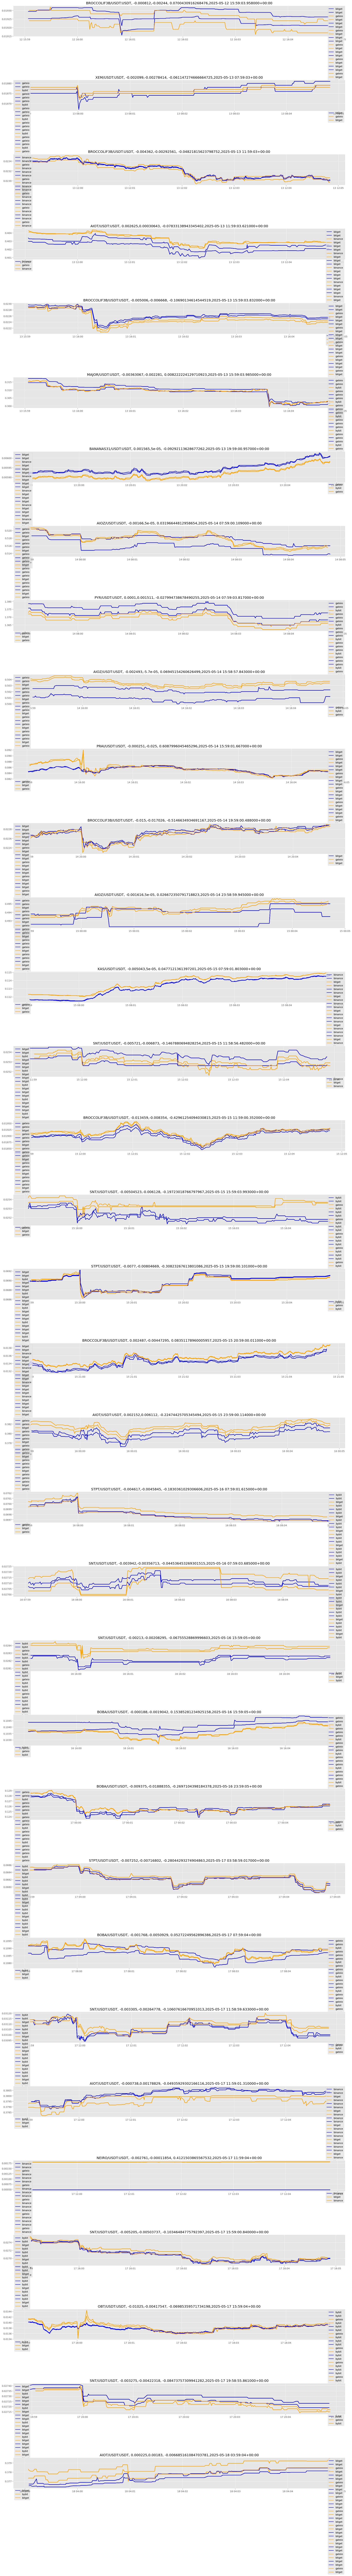

In [66]:
'''
with open('/Users/trader/Downloads/fee_record2.csv', 'r') as f:
    data = f.readlines()
filted_data = []
lens = []
for i in data:
    l = i.split(',')
    if len(l) > 20:
        if len(l) > 400:
            
            filted_data.append(l[:26] + l[206:226])
            lens.append(len(l[:26] + l[206:226]))
            
        else:
            lens.append(len(l))
            filted_data.append(l)
for i in filted_data:
    for j in range(6, len(i)):
        i[j] = eval(i[j])

filted_data = pd.DataFrame(filted_data)
'''
c1 = ['time','ex','symbol', 'fee','time2', 'fee_diff']
for i in range(1,11):
    c1.append(f'ap{i}')
    c1.append(f'av{i}')
for i in range(1,11):
    c1.append(f'bp{i}')
    c1.append(f'bv{i}')
filted_data.columns = c1

filted_data.index = pd.to_datetime(filted_data['time'])
filted_data.sort_index(inplace=True)
filted_data['fee'] = filted_data['fee'].astype('float')
filted_data['fee_diff'] = filted_data['fee_diff'].astype('float')

total_profit = []

def fee_backtest(data):
    data['mid'] = (data['ap1'] + data['bp1']) / 2
    ex_num = data['ex'].value_counts().index.to_list()
    start_time = data.index[0]
    if len(ex_num) == 2:
        ex_fee1 = data[data['ex'] == ex_num[0]]['fee'].iloc[0]
        
        #print(ex_fee1)
        ex_fee2 = data[data['ex'] == ex_num[1]]['fee'].iloc[0]
        #print(ex_fee2)
        if ex_fee1 > ex_fee2:
            short, long = ex_num[0], ex_num[1]
            short_px = data[data['ex'] == short]['bp1'].iloc[0]
            short_fee_px = data[data['ex'] == short]['mid'].iloc[50]
            fee_short = short_fee_px * ex_fee1
            long_px = data[data['ex'] == long]['ap1'].iloc[0]
            long_fee_px = data[data['ex'] == long]['mid'].iloc[50]
            fee_long = long_fee_px * ex_fee2 * -1
        else:
            short, long = ex_num[1], ex_num[0]
            short_px = data[data['ex'] == short]['bp1'].iloc[0]
            short_fee_px = data[data['ex'] == short]['mid'].iloc[50]
            fee_short = short_fee_px * ex_fee2
            long_px = data[data['ex'] == long]['ap1'].iloc[0]
            long_fee_px = data[data['ex'] == long]['mid'].iloc[50]
            fee_long = long_fee_px * ex_fee1 * -1
            
        initial_balance=20
        e = Exchange([short, long], initial_balance=initial_balance)
        amount = initial_balance / short_px

        e.Buy(short, short_px, amount)
        e.Sell(long, long_px, amount)
        short_px_close = data[data['ex'] == short]['ap1'].iloc[110]
        long_px_close = data[data['ex'] == long]['bp1'].iloc[110]

        e.Sell(short, short_px_close, amount)
        print(f"{short}----short-----{short_px}")
        print(f"{short}----close short-----{short_px_close}")
        e.Buy(long, long_px_close, amount)
        print(f"{long}----long-----{long_px}")
        print(f"{long}----close long-----{long_px_close}")
        '''
        print(fee_short * amount)
        print(fee_long * amount)
        '''
        print(fee_short)
        print(fee_short)
        print((fee_short + fee_long)*amount)
        e.account['USDT']['realised_profit'] = e.account['USDT']['realised_profit'] - (abs(fee_short) + abs(fee_short))*amount
        pprint(e.account['USDT']['fee'])
        print(e.account['USDT']['realised_profit'])
        print("--------------------------")
        total_profit.append(e.account['USDT']['realised_profit'])
        print(data[data['ex'] == short][['ap1', 'bp1']])
        
        return (data[data['ex'] == short],data[data['ex'] == long], e.account['USDT']['realised_profit'],ex_fee1, ex_fee2, short, long, start_time)
    else:
        if len(ex_num) == 3:
            data_value_counts = data['ex'].value_counts()
            resample_data = data[data['ex'] == data_value_counts.index[0]]
            merged_data1 = pd.concat([resample_data, data[data['ex'] == data_value_counts.index[1]]])
            fee_backtest(merged_data1)
            merged_data2 = pd.concat([resample_data, data[data['ex'] == data_value_counts.index[2]]])
            fee_backtest(merged_data2)
            print("--------------------------")
        else:
            return None



fig1=plt.figure(figsize=(25,450))
plt.style.use('ggplot')
n=1
next_time = filted_data.index[0]
while 1:
    cut_data = filted_data.loc[next_time:]
    if len(cut_data)  > 0:
        
        next_time = cut_data.index[0] + pd.Timedelta(minutes=10)
        #print(next_time)
        single_time = cut_data.loc[:next_time]
        
        symbols = single_time['symbol'].value_counts().index.to_list()
        #print(symbols)
        for i in symbols:
            data_symbol = single_time[single_time['symbol'] == i]
            
            re = fee_backtest(data_symbol)
            #print(len(re))
            if re:
                n = n+1
                p1=plt.subplot(160,1,n*2)
                for e in re:
                    plt.plot(re[0]['ap1'],c="b",label=re[5])
                    plt.plot(re[0]['bp1'],c="b",label=re[5])
                    
                    plt.plot(re[1]['ap1'],c='orange',label=re[6])
                    plt.plot(re[1]['bp1'],c="orange",label=re[5])
                    plt.legend()
                    plt.title(f"{i}, {re[3]},{re[4]}, {re[2]},{re[7]}")
            
    else:
        break
plt.legend()
fig1.savefig('hidra_temperture_line_chart2.pdf')


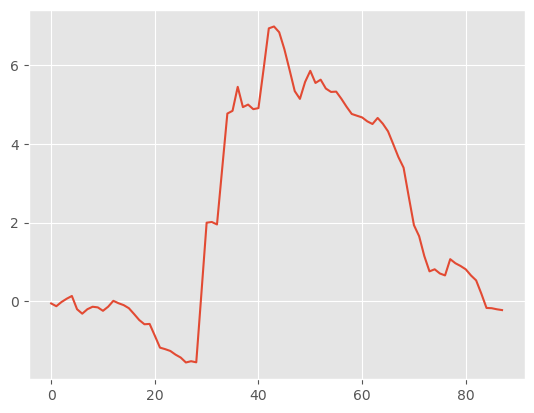

In [68]:
plt.plot(np.cumsum(total_profit))

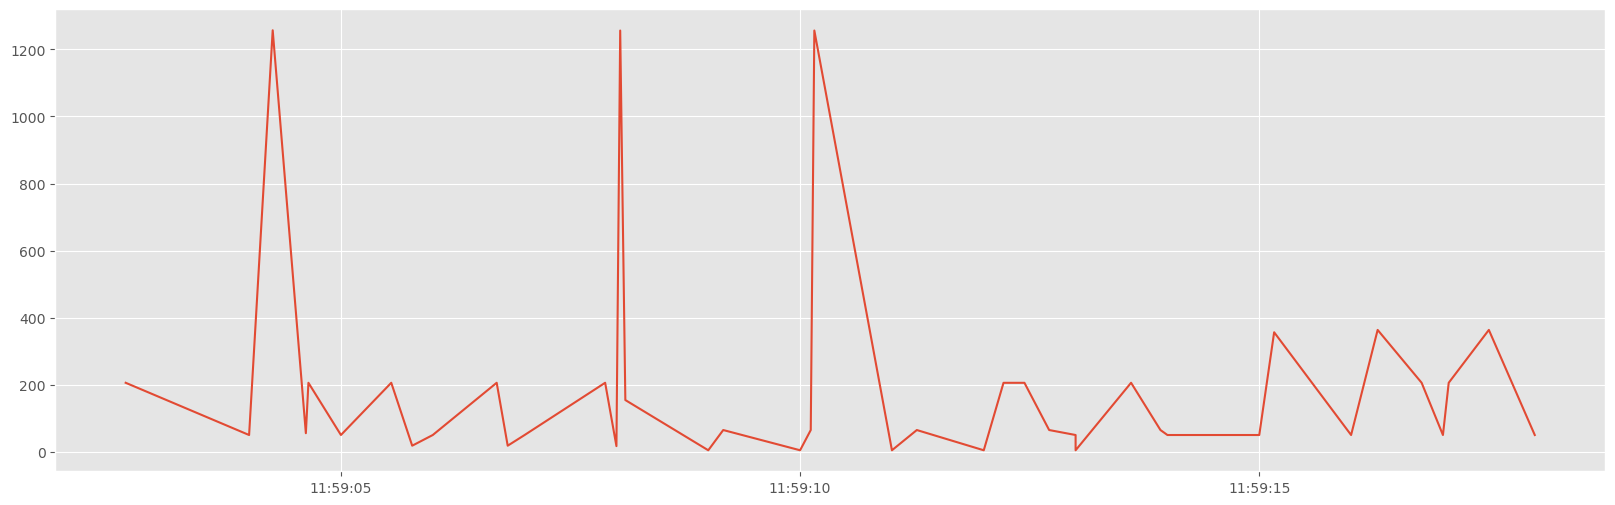

In [19]:
plt.figure(figsize=[20,6])
plt.plot((filted_data['av1'] * filted_data['ap1']).head(50))

In [22]:
snt_trade = pd.read_csv('/Users/trader/Downloads/SNTUSDT2025-05-17.csv')

In [26]:
snt_trade.index = pd.to_datetime(snt_trade['timestamp'], unit='s')

In [57]:
snt_trade_fee = snt_trade.loc['2025-05-17 19:59:52':'2025-05-17 20:00:10']
snt_depth = filted_data.loc[(filted_data['symbol']=='SNT/USDT:USDT')].query('ex=="bybit"').loc['2025-05-17 19:59:52':'2025-05-17 20:00:10']

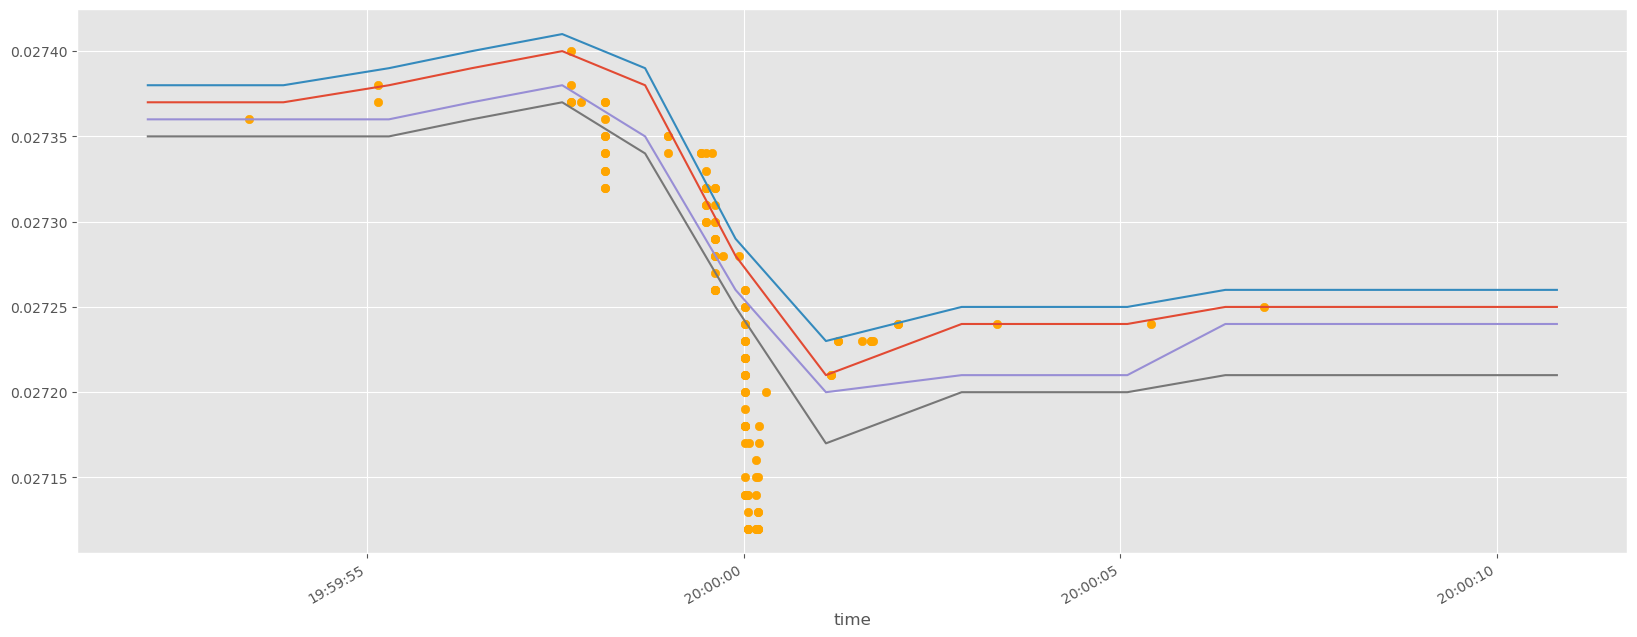

In [59]:
plt.figure(figsize=[20,8])
snt_depth['ap1'].plot()
snt_depth['ap2'].plot()
snt_depth['bp1'].plot()
snt_depth['bp2'].plot()
plt.scatter(snt_trade_fee.index, snt_trade_fee['price'],c='orange')

In [69]:
filted_data['ex'].value_counts()

ex
gateio     27000
bitget     19200
bybit      11400
binance     7800
Name: count, dtype: int64

In [71]:
a = [('binance', 0.0001, 'bybit', -0.00610802, 'XEM/USDT:USDT', 0.00620802, 1747670400000.0, 1747670400000), ('binance', 5e-05, 'bybit', -0.00240818, 'SNT/USDT:USDT', 0.0024581800000000003, 1747670400000.0, 1747670400000), ('binance', 5e-05, 'bybit', -0.00085197, 'SYS/USDT:USDT', 0.00090197, 1747670400000.0, 1747670400000), ('binance', -0.00065052, 'bybit', 5e-05, 'RONIN/USDT:USDT', 0.00070052, 1747670400000.0, 1747670400000), ('binance', 2.5e-05, 'bybit', -0.00064843, 'FLM/USDT:USDT', 0.0006734299999999999, 1747663200000.0, 1747670400000)]
pprint(a, )

TypeError: pprint() got an unexpected keyword argument 'sorted'

In [72]:
pprint?

Signature:
pprint(
    object,
    stream=None,
    indent=1,
    width=80,
    depth=None,
    *,
    compact=False,
    sort_dicts=True,
    underscore_numbers=False,
)
Docstring: Pretty-print a Python object to a stream [default is sys.stdout].
File:      /opt/anaconda3/lib/python3.12/pprint.py
Type:      function